In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline

config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
    allow_growth=True
    ))

In [2]:
# Recovery action の入ったデータ
'''
r_path = '../data/LOG_G/x1500-y-1100_fix_ball_robot_recovery_action/stable/'
contents = os.listdir(r_path)
data = pd.DataFrame()
num = 0
for c in range(len(contents)):
    print(r_path+contents[c])
    n_data = pd.read_csv(r_path+contents[c],header=None)
    data = pd.concat([data,n_data])
'''

"\nr_path = '../data/LOG_G/x1500-y-1100_fix_ball_robot_recovery_action/stable/'\ncontents = os.listdir(r_path)\ndata = pd.DataFrame()\nnum = 0\nfor c in range(len(contents)):\n    print(r_path+contents[c])\n    n_data = pd.read_csv(r_path+contents[c],header=None)\n    data = pd.concat([data,n_data])\n"

In [3]:
# ブレることなくボールをゴールに運んだデータ
#'''
target_path = '/home/yota/workspace/Study/m1/data/LOG_G/ConvertData/convData.csv'
data = pd.read_csv(target_path,header=None)

print(data)
d = data
#print(ball)
#print(joy)
#'''

             0         1         2         3         4             5    6   \
0      0.212240  0.274517  3.509918  0.147832  1.500105 -1.099784e+00  4.8   
1      0.212240  0.274517  3.509918  0.147832  1.500105 -1.099784e+00  4.8   
2      0.212240  0.274517  3.509918  0.147832  1.500105 -1.099784e+00  4.8   
3      0.212240  0.274517  3.509918  0.147832  1.500105 -1.099784e+00  4.8   
4      0.212240  0.274517  3.509918  0.147832  1.500105 -1.099784e+00  4.8   
5      0.212240  0.274517  3.509918  0.147832  1.500105 -1.099784e+00  4.8   
6      0.212240  0.274517  3.509918  0.147832  1.500105 -1.099784e+00  4.8   
7      0.212240  0.274517  3.509918  0.147832  1.500105 -1.099784e+00  4.8   
8      0.212240  0.274518  3.509920  0.147873  1.500105 -1.099784e+00  4.8   
9      0.212240  0.274518  3.509920  0.147873  1.500105 -1.099784e+00  4.8   
10     0.212240  0.274518  3.509920  0.147873  1.500105 -1.099784e+00  4.8   
11     0.212240  0.274518  3.509920  0.147873  1.500105 -1.09978

In [4]:
d.columns = ['l_bx','l_by','lc_gx','cl_gy','g_bx','g_by','g_pole0x','g_pole0y','g_pole1x','g_pole1y','g_px','g_py','g_pth','ljx','ljy','rjx','rjy']
#d = d[d.bx!=-1]

In [5]:
'''
from sklearn.cross_validation import train_test_split
t1 = []
t2 = []
def f1(x,y):
    return y * np.sin(x) + np.square(x)
def f2(x,y):
    return x * np.cos(y) + np.square(y)
for a in range(1000):
    r = np.array([np.random.rand(), np.random.rand()])
    t1.append(r)
    t2.append(np.array([ f1(r[0],r[1]),f2(r[0],r[1]) ]))
IN_train, IN_test, TAR_train, TAR_test = train_test_split(t1,t2,test_size=0.2,random_state=0)

IN_train = np.array(IN_train)
IN_test = np.array(IN_test)
TAR_train = np.array(TAR_train)
TAR_test = np.array(TAR_test)
print(IN_train[0])
print(IN_test[0])
print(TAR_train[0])
print(TAR_test[0])
print(f1(1,1))
print(f2(1,1))
'''

'\nfrom sklearn.cross_validation import train_test_split\nt1 = []\nt2 = []\ndef f1(x,y):\n    return y * np.sin(x) + np.square(x)\ndef f2(x,y):\n    return x * np.cos(y) + np.square(y)\nfor a in range(1000):\n    r = np.array([np.random.rand(), np.random.rand()])\n    t1.append(r)\n    t2.append(np.array([ f1(r[0],r[1]),f2(r[0],r[1]) ]))\nIN_train, IN_test, TAR_train, TAR_test = train_test_split(t1,t2,test_size=0.2,random_state=0)\n\nIN_train = np.array(IN_train)\nIN_test = np.array(IN_test)\nTAR_train = np.array(TAR_train)\nTAR_test = np.array(TAR_test)\nprint(IN_train[0])\nprint(IN_test[0])\nprint(TAR_train[0])\nprint(TAR_test[0])\nprint(f1(1,1))\nprint(f2(1,1))\n'

In [6]:
from sklearn.cross_validation import train_test_split

IN_size = 4
TAR_size = 3
'''
l_ball = np.array(d.iloc[:,0:2])   #  0, 1
l_pole0 = np.array(d.iloc[:,2:4])  #  2, 3
l_pole1 = np.array(d.iloc[:,4:6])  #  4, 5
g_ball = np.array(d.iloc[:,6:8])   #  6, 7
g_pole0 = np.array(d.iloc[:,8:10]) #  8, 9
g_pole1 = np.array(d.iloc[:,10:12])# 10,11
g_pos = np.array(d.iloc[:,12:15])  # 12,13,14
ljoy = np.array(d.iloc[:,15:17])   # 15,16
rjoy = np.array(d.iloc[:,17:19])   # 17,18
'''
l_ball = np.array(d.iloc[:,0:2])   #  0, 1
lc_goal = np.array(d.iloc[:,2:4])  #  2, 3
g_ball = np.array(d.iloc[:,4:6])   #  4, 5
g_pole0 = np.array(d.iloc[:,6:8]) #  6, 7
g_pole1 = np.array(d.iloc[:,8:10])# 8,9
g_pos = np.array(d.iloc[:,10:13])  # 10,11,12
ljoy = np.array(d.iloc[:,13:15])   # 13,14
rjoy = np.array(d.iloc[:,15:17])   # 15,16

input_d = np.array(d.iloc[:,0:IN_size])
output_d = np.array(d.iloc[:,13:16])
print(input_d.shape)
print(output_d.shape)



IN_train, IN_test, TAR_train, TAR_test = train_test_split(input_d,output_d,test_size=0.1,random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
#IN_train = IN_train/100.0
#IN_test = IN_test/100.0
for t in range(10):
    print(IN_train[t])
'''
print(IN_train[0])
print(IN_test[0])
print(TAR_train[0])
print(TAR_test[0])
'''

(59018, 4)
(59018, 3)
[0.84014753 0.17468594 2.27397744 1.13097117]
[ 0.34259257  0.02941903  1.01689678 -1.28106929]
[ 0.33117676 -0.33743405  1.81986345 -2.48076808]
[ 0.61591974 -0.1398737   2.79495452 -1.04204329]
[ 0.19923238  0.0218821   2.63277889 -2.04039994]
[1.27779411 0.60440076 2.96844262 3.08294252]
[0.81185694 0.29834927 2.07211931 1.27801859]
[ 0.30064744 -0.10221874  1.941217   -0.91511713]
[ 0.40105007 -0.10468939  0.76281749 -0.86996909]
[1.53980724 0.12048405 4.07768895 2.23012248]


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'\nprint(IN_train[0])\nprint(IN_test[0])\nprint(TAR_train[0])\nprint(TAR_test[0])\n'

In [7]:
#　初期化
sess = tf.Session(config=config)
test_sess = tf.Session(config=config)

INPUT = tf.placeholder(shape=[None, IN_size], dtype=tf.float32)
TARGET = tf.placeholder(shape=[None, TAR_size], dtype=tf.float32)

In [8]:
#hidden_size = [100]
hidden_size = [30,8]
batch_size = 100
iter_size = 300000

#　隠れ層の作成 （last layerに直結）
weights = []
biases = []
layers = []
tmp_size = IN_size
last_layer = INPUT
for hsize in hidden_size:
    weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, hsize])))
    biases.append(tf.Variable(tf.random_normal(shape=[hsize])))
    layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))) # 活性化関数
    tmp_size = hsize
    last_layer = layers[-1]
    print(layers[-1])
#　出力層
weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, TAR_size])))
biases.append(tf.Variable(tf.random_normal(shape=[TAR_size])))
layers.append(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))
final_output = layers[-1]
print(final_output)

Tensor("Relu:0", shape=(?, 30), dtype=float32)
Tensor("Relu_1:0", shape=(?, 8), dtype=float32)
Tensor("Add_2:0", shape=(?, 3), dtype=float32)


In [9]:
#　学習
loss = tf.losses.mean_squared_error(TARGET,final_output)
test_loss = tf.losses.mean_squared_error(TARGET,final_output)
opt = tf.train.AdamOptimizer(0.001)
#opt = tf.train.GradientDescentOptimizer(0.01)
train_step = opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)
test_sess.run(init)
loss_vec=[]
test_loss_vec=[]
for i in range(iter_size):
    train_rand_index = np.random.choice(len(IN_train), size=batch_size,replace=False)
    train_rand_in = IN_train[train_rand_index]
    train_rand_tar = TAR_train[train_rand_index]
    sess.run(train_step, feed_dict={INPUT:train_rand_in, TARGET: train_rand_tar})
    loss_vec.append(sess.run(loss, feed_dict={INPUT:train_rand_in, TARGET: train_rand_tar}))
    
    test_rand_index = np.random.choice(len(IN_test), size=batch_size,replace=False)
    test_rand_in = IN_test[test_rand_index]
    test_rand_tar = TAR_test[test_rand_index]
    test_sess.run(train_step, feed_dict={INPUT:test_rand_in, TARGET: test_rand_tar})
    test_loss_vec.append(test_sess.run(test_loss, feed_dict={INPUT:test_rand_in, TARGET: test_rand_tar}))
    
    if (i+1)%25==0:
#        print(sess.run(INPUT, feed_dict={INPUT:rand_in, TARGET: rand_tar}))
        print('Generation:'+str(i+1)+', Loss = '+str(loss_vec[-1]))

Generation:25, Loss = 312.31934
Generation:50, Loss = 297.26633
Generation:75, Loss = 145.41855
Generation:100, Loss = 96.95714
Generation:125, Loss = 53.176853
Generation:150, Loss = 27.396309
Generation:175, Loss = 32.80692
Generation:200, Loss = 18.146477
Generation:225, Loss = 12.562974
Generation:250, Loss = 11.758898
Generation:275, Loss = 6.260422
Generation:300, Loss = 8.346958
Generation:325, Loss = 5.894281
Generation:350, Loss = 5.0734396
Generation:375, Loss = 7.9442034
Generation:400, Loss = 5.5749893
Generation:425, Loss = 11.098064
Generation:450, Loss = 6.317928
Generation:475, Loss = 3.0471041
Generation:500, Loss = 3.6180067
Generation:525, Loss = 2.4244626
Generation:550, Loss = 5.49552
Generation:575, Loss = 1.8565611
Generation:600, Loss = 3.6292741
Generation:625, Loss = 2.2122066
Generation:650, Loss = 4.812157
Generation:675, Loss = 1.6750776
Generation:700, Loss = 3.7644498
Generation:725, Loss = 1.9148349
Generation:750, Loss = 1.6876756
Generation:775, Loss =

Generation:6025, Loss = 0.12735951
Generation:6050, Loss = 0.13391379
Generation:6075, Loss = 0.12237497
Generation:6100, Loss = 0.11781781
Generation:6125, Loss = 0.1116286
Generation:6150, Loss = 0.1550315
Generation:6175, Loss = 0.12182794
Generation:6200, Loss = 0.114614464
Generation:6225, Loss = 0.11853472
Generation:6250, Loss = 0.122720435
Generation:6275, Loss = 0.13023101
Generation:6300, Loss = 0.11451417
Generation:6325, Loss = 0.12673652
Generation:6350, Loss = 0.12631245
Generation:6375, Loss = 0.14362708
Generation:6400, Loss = 0.122748055
Generation:6425, Loss = 0.12691699
Generation:6450, Loss = 0.11890109
Generation:6475, Loss = 0.109870605
Generation:6500, Loss = 0.11285685
Generation:6525, Loss = 0.12518969
Generation:6550, Loss = 0.13215707
Generation:6575, Loss = 0.12849672
Generation:6600, Loss = 0.123679794
Generation:6625, Loss = 0.10812948
Generation:6650, Loss = 0.102824576
Generation:6675, Loss = 0.11405885
Generation:6700, Loss = 0.12018258
Generation:6725,

Generation:11825, Loss = 0.07282556
Generation:11850, Loss = 0.06387365
Generation:11875, Loss = 0.076325774
Generation:11900, Loss = 0.07033315
Generation:11925, Loss = 0.077496976
Generation:11950, Loss = 0.06399448
Generation:11975, Loss = 0.06681743
Generation:12000, Loss = 0.06779067
Generation:12025, Loss = 0.062180787
Generation:12050, Loss = 0.06992893
Generation:12075, Loss = 0.07161684
Generation:12100, Loss = 0.06965264
Generation:12125, Loss = 0.07602225
Generation:12150, Loss = 0.07262926
Generation:12175, Loss = 0.0612511
Generation:12200, Loss = 0.069609106
Generation:12225, Loss = 0.072176285
Generation:12250, Loss = 0.073126726
Generation:12275, Loss = 0.070105575
Generation:12300, Loss = 0.065778755
Generation:12325, Loss = 0.082152
Generation:12350, Loss = 0.07257052
Generation:12375, Loss = 0.08301719
Generation:12400, Loss = 0.07220078
Generation:12425, Loss = 0.073823124
Generation:12450, Loss = 0.056438472
Generation:12475, Loss = 0.068930656
Generation:12500, Lo

Generation:17525, Loss = 0.059574153
Generation:17550, Loss = 0.05832646
Generation:17575, Loss = 0.065319344
Generation:17600, Loss = 0.06281381
Generation:17625, Loss = 0.06828546
Generation:17650, Loss = 0.06466905
Generation:17675, Loss = 0.062190056
Generation:17700, Loss = 0.063614294
Generation:17725, Loss = 0.06896747
Generation:17750, Loss = 0.06465653
Generation:17775, Loss = 0.056879196
Generation:17800, Loss = 0.06282599
Generation:17825, Loss = 0.056937814
Generation:17850, Loss = 0.06568115
Generation:17875, Loss = 0.068880096
Generation:17900, Loss = 0.06777337
Generation:17925, Loss = 0.059155967
Generation:17950, Loss = 0.066834316
Generation:17975, Loss = 0.0695621
Generation:18000, Loss = 0.064872906
Generation:18025, Loss = 0.059157614
Generation:18050, Loss = 0.06997959
Generation:18075, Loss = 0.0624035
Generation:18100, Loss = 0.05844825
Generation:18125, Loss = 0.06600563
Generation:18150, Loss = 0.068023495
Generation:18175, Loss = 0.06867016
Generation:18200, 

Generation:23175, Loss = 0.06676358
Generation:23200, Loss = 0.06907049
Generation:23225, Loss = 0.065991536
Generation:23250, Loss = 0.06097172
Generation:23275, Loss = 0.06170187
Generation:23300, Loss = 0.055832196
Generation:23325, Loss = 0.057582017
Generation:23350, Loss = 0.055705853
Generation:23375, Loss = 0.05753362
Generation:23400, Loss = 0.059165776
Generation:23425, Loss = 0.06526008
Generation:23450, Loss = 0.056084838
Generation:23475, Loss = 0.0484506
Generation:23500, Loss = 0.067508124
Generation:23525, Loss = 0.061477203
Generation:23550, Loss = 0.052162886
Generation:23575, Loss = 0.054245688
Generation:23600, Loss = 0.05424511
Generation:23625, Loss = 0.05971105
Generation:23650, Loss = 0.05703214
Generation:23675, Loss = 0.06342579
Generation:23700, Loss = 0.06650644
Generation:23725, Loss = 0.061799806
Generation:23750, Loss = 0.05589746
Generation:23775, Loss = 0.04689951
Generation:23800, Loss = 0.059120838
Generation:23825, Loss = 0.06226911
Generation:23850,

Generation:28825, Loss = 0.04748296
Generation:28850, Loss = 0.057749975
Generation:28875, Loss = 0.05479603
Generation:28900, Loss = 0.058299243
Generation:28925, Loss = 0.06635589
Generation:28950, Loss = 0.05449803
Generation:28975, Loss = 0.062126186
Generation:29000, Loss = 0.04989493
Generation:29025, Loss = 0.05699262
Generation:29050, Loss = 0.06001539
Generation:29075, Loss = 0.062400784
Generation:29100, Loss = 0.04946656
Generation:29125, Loss = 0.048639398
Generation:29150, Loss = 0.05053515
Generation:29175, Loss = 0.050407905
Generation:29200, Loss = 0.055119883
Generation:29225, Loss = 0.05299801
Generation:29250, Loss = 0.06069734
Generation:29275, Loss = 0.05326949
Generation:29300, Loss = 0.045138557
Generation:29325, Loss = 0.051161464
Generation:29350, Loss = 0.06391673
Generation:29375, Loss = 0.06635517
Generation:29400, Loss = 0.049424484
Generation:29425, Loss = 0.058318347
Generation:29450, Loss = 0.053128064
Generation:29475, Loss = 0.05736889
Generation:29500

Generation:34475, Loss = 0.058261115
Generation:34500, Loss = 0.052541375
Generation:34525, Loss = 0.05830272
Generation:34550, Loss = 0.051250085
Generation:34575, Loss = 0.050828163
Generation:34600, Loss = 0.05192708
Generation:34625, Loss = 0.04550005
Generation:34650, Loss = 0.04064909
Generation:34675, Loss = 0.049547475
Generation:34700, Loss = 0.04574856
Generation:34725, Loss = 0.042925477
Generation:34750, Loss = 0.051371664
Generation:34775, Loss = 0.056654703
Generation:34800, Loss = 0.052459966
Generation:34825, Loss = 0.051104754
Generation:34850, Loss = 0.050246205
Generation:34875, Loss = 0.044432007
Generation:34900, Loss = 0.05019368
Generation:34925, Loss = 0.04924086
Generation:34950, Loss = 0.04920268
Generation:34975, Loss = 0.049346097
Generation:35000, Loss = 0.049675208
Generation:35025, Loss = 0.056260955
Generation:35050, Loss = 0.051553115
Generation:35075, Loss = 0.059678473
Generation:35100, Loss = 0.062084027
Generation:35125, Loss = 0.045181263
Generatio

Generation:40075, Loss = 0.046401512
Generation:40100, Loss = 0.04424269
Generation:40125, Loss = 0.046047762
Generation:40150, Loss = 0.049603265
Generation:40175, Loss = 0.05431231
Generation:40200, Loss = 0.04083153
Generation:40225, Loss = 0.047375493
Generation:40250, Loss = 0.049396683
Generation:40275, Loss = 0.05008483
Generation:40300, Loss = 0.044660445
Generation:40325, Loss = 0.050364614
Generation:40350, Loss = 0.044230703
Generation:40375, Loss = 0.04921925
Generation:40400, Loss = 0.04895103
Generation:40425, Loss = 0.044041816
Generation:40450, Loss = 0.043561216
Generation:40475, Loss = 0.053042933
Generation:40500, Loss = 0.042204116
Generation:40525, Loss = 0.047920063
Generation:40550, Loss = 0.05570866
Generation:40575, Loss = 0.044408854
Generation:40600, Loss = 0.04793723
Generation:40625, Loss = 0.042429827
Generation:40650, Loss = 0.049500152
Generation:40675, Loss = 0.04690356
Generation:40700, Loss = 0.047386028
Generation:40725, Loss = 0.053189553
Generation

Generation:45675, Loss = 0.05195662
Generation:45700, Loss = 0.051283885
Generation:45725, Loss = 0.039955035
Generation:45750, Loss = 0.059425354
Generation:45775, Loss = 0.043700233
Generation:45800, Loss = 0.03887268
Generation:45825, Loss = 0.04571619
Generation:45850, Loss = 0.050049413
Generation:45875, Loss = 0.0460733
Generation:45900, Loss = 0.05165019
Generation:45925, Loss = 0.046332024
Generation:45950, Loss = 0.05321762
Generation:45975, Loss = 0.055131976
Generation:46000, Loss = 0.05411677
Generation:46025, Loss = 0.048712626
Generation:46050, Loss = 0.04629413
Generation:46075, Loss = 0.049031723
Generation:46100, Loss = 0.05109699
Generation:46125, Loss = 0.046267223
Generation:46150, Loss = 0.03985617
Generation:46175, Loss = 0.0419956
Generation:46200, Loss = 0.038104914
Generation:46225, Loss = 0.043413315
Generation:46250, Loss = 0.035995346
Generation:46275, Loss = 0.039815977
Generation:46300, Loss = 0.04627029
Generation:46325, Loss = 0.05424227
Generation:46350

Generation:51275, Loss = 0.04090581
Generation:51300, Loss = 0.046291534
Generation:51325, Loss = 0.043291293
Generation:51350, Loss = 0.051433228
Generation:51375, Loss = 0.04843452
Generation:51400, Loss = 0.039492812
Generation:51425, Loss = 0.042037882
Generation:51450, Loss = 0.05398403
Generation:51475, Loss = 0.043623134
Generation:51500, Loss = 0.049046636
Generation:51525, Loss = 0.042337064
Generation:51550, Loss = 0.052559413
Generation:51575, Loss = 0.05085608
Generation:51600, Loss = 0.051095176
Generation:51625, Loss = 0.04729318
Generation:51650, Loss = 0.050070144
Generation:51675, Loss = 0.046451908
Generation:51700, Loss = 0.048961468
Generation:51725, Loss = 0.045198873
Generation:51750, Loss = 0.055075016
Generation:51775, Loss = 0.052116826
Generation:51800, Loss = 0.040843427
Generation:51825, Loss = 0.05029981
Generation:51850, Loss = 0.050260425
Generation:51875, Loss = 0.045795027
Generation:51900, Loss = 0.05006335
Generation:51925, Loss = 0.041725684
Generati

Generation:56875, Loss = 0.043699235
Generation:56900, Loss = 0.04821203
Generation:56925, Loss = 0.04585172
Generation:56950, Loss = 0.0528392
Generation:56975, Loss = 0.039252926
Generation:57000, Loss = 0.043543328
Generation:57025, Loss = 0.049835622
Generation:57050, Loss = 0.048331443
Generation:57075, Loss = 0.046290603
Generation:57100, Loss = 0.05289182
Generation:57125, Loss = 0.038839623
Generation:57150, Loss = 0.04105286
Generation:57175, Loss = 0.048829466
Generation:57200, Loss = 0.048141036
Generation:57225, Loss = 0.041257508
Generation:57250, Loss = 0.04795262
Generation:57275, Loss = 0.052379794
Generation:57300, Loss = 0.03869022
Generation:57325, Loss = 0.06589208
Generation:57350, Loss = 0.04285137
Generation:57375, Loss = 0.052749008
Generation:57400, Loss = 0.050474443
Generation:57425, Loss = 0.04070497
Generation:57450, Loss = 0.04204904
Generation:57475, Loss = 0.037172794
Generation:57500, Loss = 0.043132816
Generation:57525, Loss = 0.054389216
Generation:57

Generation:62475, Loss = 0.046219356
Generation:62500, Loss = 0.052979685
Generation:62525, Loss = 0.043657098
Generation:62550, Loss = 0.048139468
Generation:62575, Loss = 0.04260519
Generation:62600, Loss = 0.051144198
Generation:62625, Loss = 0.053831395
Generation:62650, Loss = 0.050647136
Generation:62675, Loss = 0.047371913
Generation:62700, Loss = 0.048042964
Generation:62725, Loss = 0.060871936
Generation:62750, Loss = 0.04027064
Generation:62775, Loss = 0.047205936
Generation:62800, Loss = 0.043048088
Generation:62825, Loss = 0.04991063
Generation:62850, Loss = 0.039570212
Generation:62875, Loss = 0.045089703
Generation:62900, Loss = 0.042647846
Generation:62925, Loss = 0.045106575
Generation:62950, Loss = 0.058358714
Generation:62975, Loss = 0.04235695
Generation:63000, Loss = 0.05123218
Generation:63025, Loss = 0.04818913
Generation:63050, Loss = 0.046308756
Generation:63075, Loss = 0.051511254
Generation:63100, Loss = 0.04547397
Generation:63125, Loss = 0.05666963
Generatio

Generation:68125, Loss = 0.042720295
Generation:68150, Loss = 0.037021525
Generation:68175, Loss = 0.045550723
Generation:68200, Loss = 0.046312198
Generation:68225, Loss = 0.051955733
Generation:68250, Loss = 0.04281002
Generation:68275, Loss = 0.0451134
Generation:68300, Loss = 0.049183626
Generation:68325, Loss = 0.05118304
Generation:68350, Loss = 0.048415538
Generation:68375, Loss = 0.038296383
Generation:68400, Loss = 0.046479084
Generation:68425, Loss = 0.047173023
Generation:68450, Loss = 0.042827673
Generation:68475, Loss = 0.043371733
Generation:68500, Loss = 0.045471374
Generation:68525, Loss = 0.040839467
Generation:68550, Loss = 0.04387079
Generation:68575, Loss = 0.04298712
Generation:68600, Loss = 0.05099062
Generation:68625, Loss = 0.039585363
Generation:68650, Loss = 0.05162538
Generation:68675, Loss = 0.051988367
Generation:68700, Loss = 0.04509643
Generation:68725, Loss = 0.04671931
Generation:68750, Loss = 0.045874786
Generation:68775, Loss = 0.050675336
Generation:

Generation:73725, Loss = 0.047725044
Generation:73750, Loss = 0.039176416
Generation:73775, Loss = 0.04436227
Generation:73800, Loss = 0.043625858
Generation:73825, Loss = 0.047904376
Generation:73850, Loss = 0.049798355
Generation:73875, Loss = 0.050465465
Generation:73900, Loss = 0.042296223
Generation:73925, Loss = 0.046870936
Generation:73950, Loss = 0.04005091
Generation:73975, Loss = 0.038913004
Generation:74000, Loss = 0.04213507
Generation:74025, Loss = 0.059827086
Generation:74050, Loss = 0.054589164
Generation:74075, Loss = 0.043295912
Generation:74100, Loss = 0.042755973
Generation:74125, Loss = 0.04316381
Generation:74150, Loss = 0.046529002
Generation:74175, Loss = 0.04623558
Generation:74200, Loss = 0.041135278
Generation:74225, Loss = 0.049961496
Generation:74250, Loss = 0.04312588
Generation:74275, Loss = 0.04399109
Generation:74300, Loss = 0.051124312
Generation:74325, Loss = 0.04039776
Generation:74350, Loss = 0.035119023
Generation:74375, Loss = 0.044923674
Generatio

Generation:79325, Loss = 0.039875675
Generation:79350, Loss = 0.046956442
Generation:79375, Loss = 0.046422753
Generation:79400, Loss = 0.043137345
Generation:79425, Loss = 0.04313336
Generation:79450, Loss = 0.040973086
Generation:79475, Loss = 0.049314484
Generation:79500, Loss = 0.0369804
Generation:79525, Loss = 0.036497824
Generation:79550, Loss = 0.04216601
Generation:79575, Loss = 0.039998993
Generation:79600, Loss = 0.04381046
Generation:79625, Loss = 0.04495845
Generation:79650, Loss = 0.04634611
Generation:79675, Loss = 0.0438752
Generation:79700, Loss = 0.042489357
Generation:79725, Loss = 0.05828469
Generation:79750, Loss = 0.044859014
Generation:79775, Loss = 0.046464387
Generation:79800, Loss = 0.038234286
Generation:79825, Loss = 0.04487492
Generation:79850, Loss = 0.048446268
Generation:79875, Loss = 0.04057415
Generation:79900, Loss = 0.033788167
Generation:79925, Loss = 0.055789795
Generation:79950, Loss = 0.052468777
Generation:79975, Loss = 0.038114067
Generation:80

Generation:84975, Loss = 0.04405466
Generation:85000, Loss = 0.05669403
Generation:85025, Loss = 0.055765655
Generation:85050, Loss = 0.044995863
Generation:85075, Loss = 0.040252298
Generation:85100, Loss = 0.0449322
Generation:85125, Loss = 0.041276567
Generation:85150, Loss = 0.048966337
Generation:85175, Loss = 0.044308674
Generation:85200, Loss = 0.03588988
Generation:85225, Loss = 0.038864695
Generation:85250, Loss = 0.044813253
Generation:85275, Loss = 0.04733534
Generation:85300, Loss = 0.03970387
Generation:85325, Loss = 0.04041259
Generation:85350, Loss = 0.04233119
Generation:85375, Loss = 0.039916713
Generation:85400, Loss = 0.042182043
Generation:85425, Loss = 0.045194875
Generation:85450, Loss = 0.04100301
Generation:85475, Loss = 0.048967298
Generation:85500, Loss = 0.04622544
Generation:85525, Loss = 0.03341248
Generation:85550, Loss = 0.058802623
Generation:85575, Loss = 0.040440593
Generation:85600, Loss = 0.039790016
Generation:85625, Loss = 0.035510696
Generation:85

Generation:90600, Loss = 0.04979264
Generation:90625, Loss = 0.042778194
Generation:90650, Loss = 0.038684294
Generation:90675, Loss = 0.054329593
Generation:90700, Loss = 0.038817506
Generation:90725, Loss = 0.030203316
Generation:90750, Loss = 0.040570203
Generation:90775, Loss = 0.043103017
Generation:90800, Loss = 0.04260781
Generation:90825, Loss = 0.042176418
Generation:90850, Loss = 0.055400703
Generation:90875, Loss = 0.04031497
Generation:90900, Loss = 0.045630977
Generation:90925, Loss = 0.047081903
Generation:90950, Loss = 0.035104852
Generation:90975, Loss = 0.042246033
Generation:91000, Loss = 0.055500913
Generation:91025, Loss = 0.059860013
Generation:91050, Loss = 0.03914563
Generation:91075, Loss = 0.04293109
Generation:91100, Loss = 0.05110358
Generation:91125, Loss = 0.043678515
Generation:91150, Loss = 0.05346075
Generation:91175, Loss = 0.04609499
Generation:91200, Loss = 0.034638483
Generation:91225, Loss = 0.04989339
Generation:91250, Loss = 0.04146734
Generation:

Generation:96225, Loss = 0.048333168
Generation:96250, Loss = 0.043492254
Generation:96275, Loss = 0.046641152
Generation:96300, Loss = 0.047206916
Generation:96325, Loss = 0.04607499
Generation:96350, Loss = 0.043633435
Generation:96375, Loss = 0.043275096
Generation:96400, Loss = 0.038007673
Generation:96425, Loss = 0.04139991
Generation:96450, Loss = 0.041176915
Generation:96475, Loss = 0.034918047
Generation:96500, Loss = 0.047196284
Generation:96525, Loss = 0.034495108
Generation:96550, Loss = 0.037292942
Generation:96575, Loss = 0.044037856
Generation:96600, Loss = 0.033983137
Generation:96625, Loss = 0.04514225
Generation:96650, Loss = 0.04748505
Generation:96675, Loss = 0.048508573
Generation:96700, Loss = 0.04322646
Generation:96725, Loss = 0.039069742
Generation:96750, Loss = 0.05055941
Generation:96775, Loss = 0.042980157
Generation:96800, Loss = 0.04547367
Generation:96825, Loss = 0.052034143
Generation:96850, Loss = 0.04965404
Generation:96875, Loss = 0.0381169
Generation:

Generation:101775, Loss = 0.03867639
Generation:101800, Loss = 0.041589152
Generation:101825, Loss = 0.040468864
Generation:101850, Loss = 0.04841057
Generation:101875, Loss = 0.03911534
Generation:101900, Loss = 0.053348884
Generation:101925, Loss = 0.03915011
Generation:101950, Loss = 0.041029815
Generation:101975, Loss = 0.046766393
Generation:102000, Loss = 0.04580304
Generation:102025, Loss = 0.044241536
Generation:102050, Loss = 0.043220904
Generation:102075, Loss = 0.04562664
Generation:102100, Loss = 0.04395003
Generation:102125, Loss = 0.03692087
Generation:102150, Loss = 0.03804322
Generation:102175, Loss = 0.056494262
Generation:102200, Loss = 0.034585353
Generation:102225, Loss = 0.045356885
Generation:102250, Loss = 0.04313234
Generation:102275, Loss = 0.041623805
Generation:102300, Loss = 0.045131497
Generation:102325, Loss = 0.044228744
Generation:102350, Loss = 0.04015955
Generation:102375, Loss = 0.03624435
Generation:102400, Loss = 0.040690776
Generation:102425, Loss 

Generation:107225, Loss = 0.04398456
Generation:107250, Loss = 0.03729907
Generation:107275, Loss = 0.035224058
Generation:107300, Loss = 0.04006764
Generation:107325, Loss = 0.041311905
Generation:107350, Loss = 0.035925377
Generation:107375, Loss = 0.038449205
Generation:107400, Loss = 0.036364045
Generation:107425, Loss = 0.038160965
Generation:107450, Loss = 0.046905324
Generation:107475, Loss = 0.0432363
Generation:107500, Loss = 0.044600405
Generation:107525, Loss = 0.048519924
Generation:107550, Loss = 0.035128426
Generation:107575, Loss = 0.03873785
Generation:107600, Loss = 0.041815348
Generation:107625, Loss = 0.03739486
Generation:107650, Loss = 0.049213316
Generation:107675, Loss = 0.038111527
Generation:107700, Loss = 0.03535484
Generation:107725, Loss = 0.042734366
Generation:107750, Loss = 0.03842688
Generation:107775, Loss = 0.045166742
Generation:107800, Loss = 0.044279136
Generation:107825, Loss = 0.041167177
Generation:107850, Loss = 0.035540562
Generation:107875, Lo

Generation:112675, Loss = 0.03593121
Generation:112700, Loss = 0.03843794
Generation:112725, Loss = 0.04079555
Generation:112750, Loss = 0.038837563
Generation:112775, Loss = 0.044842348
Generation:112800, Loss = 0.037395496
Generation:112825, Loss = 0.043235064
Generation:112850, Loss = 0.040730372
Generation:112875, Loss = 0.04323249
Generation:112900, Loss = 0.044639315
Generation:112925, Loss = 0.047004342
Generation:112950, Loss = 0.037915103
Generation:112975, Loss = 0.04153963
Generation:113000, Loss = 0.036580727
Generation:113025, Loss = 0.041038264
Generation:113050, Loss = 0.051704157
Generation:113075, Loss = 0.044381715
Generation:113100, Loss = 0.03665262
Generation:113125, Loss = 0.04027426
Generation:113150, Loss = 0.041632276
Generation:113175, Loss = 0.042574003
Generation:113200, Loss = 0.038693797
Generation:113225, Loss = 0.033837408
Generation:113250, Loss = 0.047060236
Generation:113275, Loss = 0.042213146
Generation:113300, Loss = 0.03939232
Generation:113325, L

Generation:118125, Loss = 0.03902717
Generation:118150, Loss = 0.03292407
Generation:118175, Loss = 0.04698736
Generation:118200, Loss = 0.04309804
Generation:118225, Loss = 0.047881335
Generation:118250, Loss = 0.04965562
Generation:118275, Loss = 0.041690562
Generation:118300, Loss = 0.033229582
Generation:118325, Loss = 0.041385062
Generation:118350, Loss = 0.037592422
Generation:118375, Loss = 0.038470007
Generation:118400, Loss = 0.033069644
Generation:118425, Loss = 0.04342941
Generation:118450, Loss = 0.045254946
Generation:118475, Loss = 0.05204157
Generation:118500, Loss = 0.042724065
Generation:118525, Loss = 0.037427634
Generation:118550, Loss = 0.03396873
Generation:118575, Loss = 0.045779075
Generation:118600, Loss = 0.044612657
Generation:118625, Loss = 0.03853416
Generation:118650, Loss = 0.047780443
Generation:118675, Loss = 0.04897113
Generation:118700, Loss = 0.041990478
Generation:118725, Loss = 0.03931302
Generation:118750, Loss = 0.048808858
Generation:118775, Loss

Generation:123625, Loss = 0.03946792
Generation:123650, Loss = 0.04128964
Generation:123675, Loss = 0.031912994
Generation:123700, Loss = 0.04562199
Generation:123725, Loss = 0.04188928
Generation:123750, Loss = 0.048019644
Generation:123775, Loss = 0.048142076
Generation:123800, Loss = 0.043540552
Generation:123825, Loss = 0.038162846
Generation:123850, Loss = 0.050120004
Generation:123875, Loss = 0.04331248
Generation:123900, Loss = 0.03757591
Generation:123925, Loss = 0.039346684
Generation:123950, Loss = 0.040574018
Generation:123975, Loss = 0.042363714
Generation:124000, Loss = 0.03869935
Generation:124025, Loss = 0.049912605
Generation:124050, Loss = 0.045932293
Generation:124075, Loss = 0.039049376
Generation:124100, Loss = 0.03980993
Generation:124125, Loss = 0.040300068
Generation:124150, Loss = 0.043477498
Generation:124175, Loss = 0.039526448
Generation:124200, Loss = 0.035252165
Generation:124225, Loss = 0.04032668
Generation:124250, Loss = 0.042566046
Generation:124275, Lo

Generation:129075, Loss = 0.046776246
Generation:129100, Loss = 0.041554715
Generation:129125, Loss = 0.035675224
Generation:129150, Loss = 0.04153994
Generation:129175, Loss = 0.038176026
Generation:129200, Loss = 0.04744834
Generation:129225, Loss = 0.030584024
Generation:129250, Loss = 0.037355002
Generation:129275, Loss = 0.040311728
Generation:129300, Loss = 0.03879226
Generation:129325, Loss = 0.03919631
Generation:129350, Loss = 0.051000528
Generation:129375, Loss = 0.042619962
Generation:129400, Loss = 0.033457
Generation:129425, Loss = 0.040757548
Generation:129450, Loss = 0.04242426
Generation:129475, Loss = 0.035879817
Generation:129500, Loss = 0.037697572
Generation:129525, Loss = 0.055267442
Generation:129550, Loss = 0.036728878
Generation:129575, Loss = 0.030685581
Generation:129600, Loss = 0.044705685
Generation:129625, Loss = 0.038964577
Generation:129650, Loss = 0.041044623
Generation:129675, Loss = 0.037984263
Generation:129700, Loss = 0.036308713
Generation:129725, L

Generation:134525, Loss = 0.04385903
Generation:134550, Loss = 0.043909084
Generation:134575, Loss = 0.034788385
Generation:134600, Loss = 0.04284029
Generation:134625, Loss = 0.041479345
Generation:134650, Loss = 0.04360346
Generation:134675, Loss = 0.041834626
Generation:134700, Loss = 0.04235574
Generation:134725, Loss = 0.035893735
Generation:134750, Loss = 0.036285102
Generation:134775, Loss = 0.040206835
Generation:134800, Loss = 0.046186816
Generation:134825, Loss = 0.038874235
Generation:134850, Loss = 0.0345953
Generation:134875, Loss = 0.039062418
Generation:134900, Loss = 0.0348148
Generation:134925, Loss = 0.03849924
Generation:134950, Loss = 0.038854983
Generation:134975, Loss = 0.034382924
Generation:135000, Loss = 0.036466513
Generation:135025, Loss = 0.039600145
Generation:135050, Loss = 0.04857954
Generation:135075, Loss = 0.041605517
Generation:135100, Loss = 0.041573144
Generation:135125, Loss = 0.04333792
Generation:135150, Loss = 0.0352846
Generation:135175, Loss =

Generation:140025, Loss = 0.044521093
Generation:140050, Loss = 0.041557055
Generation:140075, Loss = 0.0467816
Generation:140100, Loss = 0.042794563
Generation:140125, Loss = 0.045890875
Generation:140150, Loss = 0.038057014
Generation:140175, Loss = 0.040932298
Generation:140200, Loss = 0.039399203
Generation:140225, Loss = 0.03729209
Generation:140250, Loss = 0.045016598
Generation:140275, Loss = 0.03616987
Generation:140300, Loss = 0.03900261
Generation:140325, Loss = 0.04682628
Generation:140350, Loss = 0.032805
Generation:140375, Loss = 0.035364855
Generation:140400, Loss = 0.047889568
Generation:140425, Loss = 0.03240059
Generation:140450, Loss = 0.040214594
Generation:140475, Loss = 0.04415107
Generation:140500, Loss = 0.033638556
Generation:140525, Loss = 0.03555405
Generation:140550, Loss = 0.038512398
Generation:140575, Loss = 0.03730095
Generation:140600, Loss = 0.040630527
Generation:140625, Loss = 0.031308904
Generation:140650, Loss = 0.047876194
Generation:140675, Loss =

Generation:145475, Loss = 0.037015006
Generation:145500, Loss = 0.03542242
Generation:145525, Loss = 0.04911933
Generation:145550, Loss = 0.037376218
Generation:145575, Loss = 0.043565173
Generation:145600, Loss = 0.043252934
Generation:145625, Loss = 0.03918701
Generation:145650, Loss = 0.0411369
Generation:145675, Loss = 0.033827096
Generation:145700, Loss = 0.041733373
Generation:145725, Loss = 0.049455937
Generation:145750, Loss = 0.047106646
Generation:145775, Loss = 0.035800386
Generation:145800, Loss = 0.04217924
Generation:145825, Loss = 0.030693572
Generation:145850, Loss = 0.03449328
Generation:145875, Loss = 0.04157321
Generation:145900, Loss = 0.04264598
Generation:145925, Loss = 0.041960582
Generation:145950, Loss = 0.042102497
Generation:145975, Loss = 0.037458036
Generation:146000, Loss = 0.038292903
Generation:146025, Loss = 0.034731247
Generation:146050, Loss = 0.036188006
Generation:146075, Loss = 0.04542182
Generation:146100, Loss = 0.037762668
Generation:146125, Los

Generation:150975, Loss = 0.03537286
Generation:151000, Loss = 0.03795689
Generation:151025, Loss = 0.0436037
Generation:151050, Loss = 0.041919924
Generation:151075, Loss = 0.029126879
Generation:151100, Loss = 0.04259259
Generation:151125, Loss = 0.038001638
Generation:151150, Loss = 0.038780276
Generation:151175, Loss = 0.03635456
Generation:151200, Loss = 0.033878304
Generation:151225, Loss = 0.040272575
Generation:151250, Loss = 0.039232157
Generation:151275, Loss = 0.040968906
Generation:151300, Loss = 0.031365655
Generation:151325, Loss = 0.0408037
Generation:151350, Loss = 0.036876123
Generation:151375, Loss = 0.041738752
Generation:151400, Loss = 0.04555778
Generation:151425, Loss = 0.04238114
Generation:151450, Loss = 0.04254731
Generation:151475, Loss = 0.04838584
Generation:151500, Loss = 0.045258317
Generation:151525, Loss = 0.03859359
Generation:151550, Loss = 0.03148702
Generation:151575, Loss = 0.039960828
Generation:151600, Loss = 0.0348064
Generation:151625, Loss = 0.

Generation:156475, Loss = 0.04151267
Generation:156500, Loss = 0.041932665
Generation:156525, Loss = 0.03377616
Generation:156550, Loss = 0.034379732
Generation:156575, Loss = 0.04355981
Generation:156600, Loss = 0.035833806
Generation:156625, Loss = 0.039310694
Generation:156650, Loss = 0.04189512
Generation:156675, Loss = 0.039402287
Generation:156700, Loss = 0.038972337
Generation:156725, Loss = 0.051965464
Generation:156750, Loss = 0.04202776
Generation:156775, Loss = 0.037873875
Generation:156800, Loss = 0.038259886
Generation:156825, Loss = 0.033239357
Generation:156850, Loss = 0.038435858
Generation:156875, Loss = 0.0340788
Generation:156900, Loss = 0.040822085
Generation:156925, Loss = 0.040658664
Generation:156950, Loss = 0.03656235
Generation:156975, Loss = 0.041666724
Generation:157000, Loss = 0.035713755
Generation:157025, Loss = 0.041486263
Generation:157050, Loss = 0.038240686
Generation:157075, Loss = 0.04061156
Generation:157100, Loss = 0.04464095
Generation:157125, Los

Generation:161925, Loss = 0.039702125
Generation:161950, Loss = 0.041695602
Generation:161975, Loss = 0.03601706
Generation:162000, Loss = 0.04285716
Generation:162025, Loss = 0.04290404
Generation:162050, Loss = 0.036584284
Generation:162075, Loss = 0.04339863
Generation:162100, Loss = 0.045945697
Generation:162125, Loss = 0.035429776
Generation:162150, Loss = 0.043031774
Generation:162175, Loss = 0.040327296
Generation:162200, Loss = 0.04077102
Generation:162225, Loss = 0.034260195
Generation:162250, Loss = 0.04377799
Generation:162275, Loss = 0.03766164
Generation:162300, Loss = 0.03916166
Generation:162325, Loss = 0.033336658
Generation:162350, Loss = 0.03983455
Generation:162375, Loss = 0.040889982
Generation:162400, Loss = 0.039411083
Generation:162425, Loss = 0.041764695
Generation:162450, Loss = 0.03786734
Generation:162475, Loss = 0.040619876
Generation:162500, Loss = 0.041762773
Generation:162525, Loss = 0.042159647
Generation:162550, Loss = 0.04034165
Generation:162575, Loss

Generation:167425, Loss = 0.03873561
Generation:167450, Loss = 0.04143081
Generation:167475, Loss = 0.045769215
Generation:167500, Loss = 0.031011825
Generation:167525, Loss = 0.035957318
Generation:167550, Loss = 0.033861913
Generation:167575, Loss = 0.03957298
Generation:167600, Loss = 0.040363066
Generation:167625, Loss = 0.04282218
Generation:167650, Loss = 0.038709145
Generation:167675, Loss = 0.037961043
Generation:167700, Loss = 0.035495695
Generation:167725, Loss = 0.03946622
Generation:167750, Loss = 0.038096398
Generation:167775, Loss = 0.03854213
Generation:167800, Loss = 0.039094437
Generation:167825, Loss = 0.033611502
Generation:167850, Loss = 0.03482968
Generation:167875, Loss = 0.049794964
Generation:167900, Loss = 0.03599787
Generation:167925, Loss = 0.04082299
Generation:167950, Loss = 0.041976504
Generation:167975, Loss = 0.044728372
Generation:168000, Loss = 0.04002756
Generation:168025, Loss = 0.034222223
Generation:168050, Loss = 0.042450704
Generation:168075, Los

Generation:172875, Loss = 0.04008846
Generation:172900, Loss = 0.033715673
Generation:172925, Loss = 0.03667111
Generation:172950, Loss = 0.03567912
Generation:172975, Loss = 0.029700244
Generation:173000, Loss = 0.041096795
Generation:173025, Loss = 0.04230184
Generation:173050, Loss = 0.0404571
Generation:173075, Loss = 0.044051096
Generation:173100, Loss = 0.03250623
Generation:173125, Loss = 0.044397086
Generation:173150, Loss = 0.035934877
Generation:173175, Loss = 0.036208227
Generation:173200, Loss = 0.037630454
Generation:173225, Loss = 0.03657844
Generation:173250, Loss = 0.036586598
Generation:173275, Loss = 0.04318302
Generation:173300, Loss = 0.032287978
Generation:173325, Loss = 0.040750645
Generation:173350, Loss = 0.032806594
Generation:173375, Loss = 0.04787227
Generation:173400, Loss = 0.04001121
Generation:173425, Loss = 0.030419556
Generation:173450, Loss = 0.039030455
Generation:173475, Loss = 0.03691121
Generation:173500, Loss = 0.042465337
Generation:173525, Loss 

Generation:178325, Loss = 0.0436011
Generation:178350, Loss = 0.04062722
Generation:178375, Loss = 0.036771145
Generation:178400, Loss = 0.04026338
Generation:178425, Loss = 0.042459637
Generation:178450, Loss = 0.030996777
Generation:178475, Loss = 0.044436704
Generation:178500, Loss = 0.04118029
Generation:178525, Loss = 0.039775092
Generation:178550, Loss = 0.03432928
Generation:178575, Loss = 0.041271433
Generation:178600, Loss = 0.03989613
Generation:178625, Loss = 0.035950515
Generation:178650, Loss = 0.037417095
Generation:178675, Loss = 0.04549083
Generation:178700, Loss = 0.039392464
Generation:178725, Loss = 0.03684462
Generation:178750, Loss = 0.036593776
Generation:178775, Loss = 0.042254385
Generation:178800, Loss = 0.036063965
Generation:178825, Loss = 0.0447601
Generation:178850, Loss = 0.04141091
Generation:178875, Loss = 0.032859597
Generation:178900, Loss = 0.04275835
Generation:178925, Loss = 0.04841363
Generation:178950, Loss = 0.037892178
Generation:178975, Loss = 

Generation:183825, Loss = 0.034765672
Generation:183850, Loss = 0.044688836
Generation:183875, Loss = 0.041338563
Generation:183900, Loss = 0.037177768
Generation:183925, Loss = 0.043441862
Generation:183950, Loss = 0.03545176
Generation:183975, Loss = 0.034480393
Generation:184000, Loss = 0.035749283
Generation:184025, Loss = 0.03162952
Generation:184050, Loss = 0.039919306
Generation:184075, Loss = 0.04139114
Generation:184100, Loss = 0.03291759
Generation:184125, Loss = 0.03532896
Generation:184150, Loss = 0.037911963
Generation:184175, Loss = 0.036681823
Generation:184200, Loss = 0.038617834
Generation:184225, Loss = 0.041409455
Generation:184250, Loss = 0.049118266
Generation:184275, Loss = 0.040227577
Generation:184300, Loss = 0.035027504
Generation:184325, Loss = 0.040037327
Generation:184350, Loss = 0.04755122
Generation:184375, Loss = 0.043754224
Generation:184400, Loss = 0.04157474
Generation:184425, Loss = 0.04017701
Generation:184450, Loss = 0.040769827
Generation:184475, L

Generation:189275, Loss = 0.03935598
Generation:189300, Loss = 0.040437162
Generation:189325, Loss = 0.037448503
Generation:189350, Loss = 0.040522743
Generation:189375, Loss = 0.03965336
Generation:189400, Loss = 0.042436022
Generation:189425, Loss = 0.034909822
Generation:189450, Loss = 0.044556785
Generation:189475, Loss = 0.04810566
Generation:189500, Loss = 0.04026878
Generation:189525, Loss = 0.046522766
Generation:189550, Loss = 0.03657726
Generation:189575, Loss = 0.033531923
Generation:189600, Loss = 0.038783565
Generation:189625, Loss = 0.040562198
Generation:189650, Loss = 0.038329232
Generation:189675, Loss = 0.045066897
Generation:189700, Loss = 0.03833922
Generation:189725, Loss = 0.043701228
Generation:189750, Loss = 0.041695796
Generation:189775, Loss = 0.03933541
Generation:189800, Loss = 0.04067162
Generation:189825, Loss = 0.03908122
Generation:189850, Loss = 0.039422404
Generation:189875, Loss = 0.036838513
Generation:189900, Loss = 0.051880967
Generation:189925, Lo

Generation:194725, Loss = 0.027013868
Generation:194750, Loss = 0.039436582
Generation:194775, Loss = 0.035647005
Generation:194800, Loss = 0.033450786
Generation:194825, Loss = 0.041021213
Generation:194850, Loss = 0.04297367
Generation:194875, Loss = 0.04141736
Generation:194900, Loss = 0.034074403
Generation:194925, Loss = 0.04062447
Generation:194950, Loss = 0.039589792
Generation:194975, Loss = 0.041917894
Generation:195000, Loss = 0.039765496
Generation:195025, Loss = 0.036636468
Generation:195050, Loss = 0.037391584
Generation:195075, Loss = 0.03791295
Generation:195100, Loss = 0.042167205
Generation:195125, Loss = 0.046697456
Generation:195150, Loss = 0.03842455
Generation:195175, Loss = 0.040535957
Generation:195200, Loss = 0.03825516
Generation:195225, Loss = 0.039932217
Generation:195250, Loss = 0.03401211
Generation:195275, Loss = 0.034520175
Generation:195300, Loss = 0.036248803
Generation:195325, Loss = 0.042909723
Generation:195350, Loss = 0.03820546
Generation:195375, L

Generation:200175, Loss = 0.032777544
Generation:200200, Loss = 0.03572415
Generation:200225, Loss = 0.031140944
Generation:200250, Loss = 0.041484214
Generation:200275, Loss = 0.038740978
Generation:200300, Loss = 0.04430174
Generation:200325, Loss = 0.036670312
Generation:200350, Loss = 0.03251309
Generation:200375, Loss = 0.030894337
Generation:200400, Loss = 0.031109922
Generation:200425, Loss = 0.038983736
Generation:200450, Loss = 0.044366572
Generation:200475, Loss = 0.04165346
Generation:200500, Loss = 0.040617954
Generation:200525, Loss = 0.03563338
Generation:200550, Loss = 0.038805515
Generation:200575, Loss = 0.040903833
Generation:200600, Loss = 0.04028078
Generation:200625, Loss = 0.039387345
Generation:200650, Loss = 0.036572006
Generation:200675, Loss = 0.031456977
Generation:200700, Loss = 0.037110724
Generation:200725, Loss = 0.041471362
Generation:200750, Loss = 0.032638863
Generation:200775, Loss = 0.039833292
Generation:200800, Loss = 0.034787152
Generation:200825,

Generation:205675, Loss = 0.035293307
Generation:205700, Loss = 0.03803711
Generation:205725, Loss = 0.036756676
Generation:205750, Loss = 0.040910013
Generation:205775, Loss = 0.034698375
Generation:205800, Loss = 0.029669302
Generation:205825, Loss = 0.028288154
Generation:205850, Loss = 0.037752293
Generation:205875, Loss = 0.034251362
Generation:205900, Loss = 0.031414337
Generation:205925, Loss = 0.032361496
Generation:205950, Loss = 0.026706029
Generation:205975, Loss = 0.031525083
Generation:206000, Loss = 0.03798728
Generation:206025, Loss = 0.034584984
Generation:206050, Loss = 0.038432945
Generation:206075, Loss = 0.036741067
Generation:206100, Loss = 0.037043665
Generation:206125, Loss = 0.042118862
Generation:206150, Loss = 0.046238884
Generation:206175, Loss = 0.038732346
Generation:206200, Loss = 0.03585914
Generation:206225, Loss = 0.038010247
Generation:206250, Loss = 0.035203334
Generation:206275, Loss = 0.045425087
Generation:206300, Loss = 0.042564653
Generation:2063

Generation:211125, Loss = 0.04271515
Generation:211150, Loss = 0.033874243
Generation:211175, Loss = 0.035680976
Generation:211200, Loss = 0.03324031
Generation:211225, Loss = 0.03662958
Generation:211250, Loss = 0.041196723
Generation:211275, Loss = 0.036994558
Generation:211300, Loss = 0.03250026
Generation:211325, Loss = 0.03966894
Generation:211350, Loss = 0.03114274
Generation:211375, Loss = 0.03488669
Generation:211400, Loss = 0.03842028
Generation:211425, Loss = 0.044247184
Generation:211450, Loss = 0.03223621
Generation:211475, Loss = 0.041383248
Generation:211500, Loss = 0.043794893
Generation:211525, Loss = 0.035080384
Generation:211550, Loss = 0.035996903
Generation:211575, Loss = 0.033229172
Generation:211600, Loss = 0.03637788
Generation:211625, Loss = 0.041618347
Generation:211650, Loss = 0.037882593
Generation:211675, Loss = 0.034903385
Generation:211700, Loss = 0.039990027
Generation:211725, Loss = 0.035957064
Generation:211750, Loss = 0.03363028
Generation:211775, Loss

Generation:216575, Loss = 0.036215935
Generation:216600, Loss = 0.039581418
Generation:216625, Loss = 0.044895425
Generation:216650, Loss = 0.033492714
Generation:216675, Loss = 0.04388286
Generation:216700, Loss = 0.032115098
Generation:216725, Loss = 0.040243536
Generation:216750, Loss = 0.035819713
Generation:216775, Loss = 0.03667557
Generation:216800, Loss = 0.03491282
Generation:216825, Loss = 0.04895211
Generation:216850, Loss = 0.026604624
Generation:216875, Loss = 0.040637888
Generation:216900, Loss = 0.037258286
Generation:216925, Loss = 0.039042
Generation:216950, Loss = 0.047688413
Generation:216975, Loss = 0.036997113
Generation:217000, Loss = 0.048950832
Generation:217025, Loss = 0.051025067
Generation:217050, Loss = 0.04162315
Generation:217075, Loss = 0.041228514
Generation:217100, Loss = 0.039576277
Generation:217125, Loss = 0.033172604
Generation:217150, Loss = 0.037824687
Generation:217175, Loss = 0.035963483
Generation:217200, Loss = 0.044086754
Generation:217225, L

Generation:222025, Loss = 0.030656576
Generation:222050, Loss = 0.03784838
Generation:222075, Loss = 0.03445908
Generation:222100, Loss = 0.047868855
Generation:222125, Loss = 0.04259076
Generation:222150, Loss = 0.05113756
Generation:222175, Loss = 0.039776586
Generation:222200, Loss = 0.03226128
Generation:222225, Loss = 0.043144796
Generation:222250, Loss = 0.044433285
Generation:222275, Loss = 0.037921358
Generation:222300, Loss = 0.040696315
Generation:222325, Loss = 0.026855733
Generation:222350, Loss = 0.043127965
Generation:222375, Loss = 0.035247598
Generation:222400, Loss = 0.037185673
Generation:222425, Loss = 0.03868076
Generation:222450, Loss = 0.038270235
Generation:222475, Loss = 0.031620707
Generation:222500, Loss = 0.030340163
Generation:222525, Loss = 0.042750508
Generation:222550, Loss = 0.033626925
Generation:222575, Loss = 0.04224134
Generation:222600, Loss = 0.036871616
Generation:222625, Loss = 0.03643781
Generation:222650, Loss = 0.04127493
Generation:222675, Lo

Generation:227475, Loss = 0.038599983
Generation:227500, Loss = 0.038405675
Generation:227525, Loss = 0.036097918
Generation:227550, Loss = 0.040010326
Generation:227575, Loss = 0.042191036
Generation:227600, Loss = 0.04790586
Generation:227625, Loss = 0.047062237
Generation:227650, Loss = 0.038139164
Generation:227675, Loss = 0.038774505
Generation:227700, Loss = 0.032496173
Generation:227725, Loss = 0.035376295
Generation:227750, Loss = 0.0369438
Generation:227775, Loss = 0.031469274
Generation:227800, Loss = 0.04205581
Generation:227825, Loss = 0.039461054
Generation:227850, Loss = 0.039331432
Generation:227875, Loss = 0.03768053
Generation:227900, Loss = 0.02894357
Generation:227925, Loss = 0.04391541
Generation:227950, Loss = 0.0397932
Generation:227975, Loss = 0.037839632
Generation:228000, Loss = 0.043455817
Generation:228025, Loss = 0.054100946
Generation:228050, Loss = 0.034015775
Generation:228075, Loss = 0.03799965
Generation:228100, Loss = 0.025367148
Generation:228125, Los

Generation:232925, Loss = 0.03630379
Generation:232950, Loss = 0.038805477
Generation:232975, Loss = 0.036132235
Generation:233000, Loss = 0.037255324
Generation:233025, Loss = 0.040891703
Generation:233050, Loss = 0.04715136
Generation:233075, Loss = 0.035892442
Generation:233100, Loss = 0.0426462
Generation:233125, Loss = 0.035852525
Generation:233150, Loss = 0.04144567
Generation:233175, Loss = 0.046239153
Generation:233200, Loss = 0.037863053
Generation:233225, Loss = 0.036170337
Generation:233250, Loss = 0.036713015
Generation:233275, Loss = 0.045678534
Generation:233300, Loss = 0.04424662
Generation:233325, Loss = 0.033148006
Generation:233350, Loss = 0.04617349
Generation:233375, Loss = 0.040432014
Generation:233400, Loss = 0.0315502
Generation:233425, Loss = 0.048944585
Generation:233450, Loss = 0.04418324
Generation:233475, Loss = 0.038831964
Generation:233500, Loss = 0.038447674
Generation:233525, Loss = 0.042779714
Generation:233550, Loss = 0.037594553
Generation:233575, Los

Generation:238425, Loss = 0.035739772
Generation:238450, Loss = 0.033624936
Generation:238475, Loss = 0.03585762
Generation:238500, Loss = 0.03525956
Generation:238525, Loss = 0.03186079
Generation:238550, Loss = 0.03117214
Generation:238575, Loss = 0.036596775
Generation:238600, Loss = 0.039338205
Generation:238625, Loss = 0.04356949
Generation:238650, Loss = 0.031881064
Generation:238675, Loss = 0.041026648
Generation:238700, Loss = 0.033730753
Generation:238725, Loss = 0.039266985
Generation:238750, Loss = 0.033433255
Generation:238775, Loss = 0.035986308
Generation:238800, Loss = 0.040788256
Generation:238825, Loss = 0.04768349
Generation:238850, Loss = 0.044970922
Generation:238875, Loss = 0.03716101
Generation:238900, Loss = 0.033119798
Generation:238925, Loss = 0.043540765
Generation:238950, Loss = 0.040638797
Generation:238975, Loss = 0.039684676
Generation:239000, Loss = 0.029882345
Generation:239025, Loss = 0.033733647
Generation:239050, Loss = 0.041337535
Generation:239075, 

Generation:243925, Loss = 0.030516697
Generation:243950, Loss = 0.03800132
Generation:243975, Loss = 0.041163433
Generation:244000, Loss = 0.038793717
Generation:244025, Loss = 0.041373577
Generation:244050, Loss = 0.036088802
Generation:244075, Loss = 0.038776487
Generation:244100, Loss = 0.035276346
Generation:244125, Loss = 0.04069124
Generation:244150, Loss = 0.04046084
Generation:244175, Loss = 0.040678892
Generation:244200, Loss = 0.045539524
Generation:244225, Loss = 0.043404337
Generation:244250, Loss = 0.042884037
Generation:244275, Loss = 0.03372915
Generation:244300, Loss = 0.04108734
Generation:244325, Loss = 0.03856319
Generation:244350, Loss = 0.0439776
Generation:244375, Loss = 0.029778099
Generation:244400, Loss = 0.030349502
Generation:244425, Loss = 0.045959204
Generation:244450, Loss = 0.04354825
Generation:244475, Loss = 0.027686803
Generation:244500, Loss = 0.040808626
Generation:244525, Loss = 0.033795036
Generation:244550, Loss = 0.041451056
Generation:244575, Lo

Generation:249425, Loss = 0.038549412
Generation:249450, Loss = 0.034964897
Generation:249475, Loss = 0.030708957
Generation:249500, Loss = 0.036618486
Generation:249525, Loss = 0.030985707
Generation:249550, Loss = 0.03875229
Generation:249575, Loss = 0.03945942
Generation:249600, Loss = 0.034341387
Generation:249625, Loss = 0.031272963
Generation:249650, Loss = 0.035986234
Generation:249675, Loss = 0.03560643
Generation:249700, Loss = 0.038044184
Generation:249725, Loss = 0.03543918
Generation:249750, Loss = 0.042260323
Generation:249775, Loss = 0.036368474
Generation:249800, Loss = 0.034627058
Generation:249825, Loss = 0.037305124
Generation:249850, Loss = 0.038878728
Generation:249875, Loss = 0.035657372
Generation:249900, Loss = 0.029419525
Generation:249925, Loss = 0.04012635
Generation:249950, Loss = 0.028823875
Generation:249975, Loss = 0.03724985
Generation:250000, Loss = 0.043831285
Generation:250025, Loss = 0.042279314
Generation:250050, Loss = 0.036438167
Generation:250075,

Generation:254875, Loss = 0.039022777
Generation:254900, Loss = 0.040490497
Generation:254925, Loss = 0.037013553
Generation:254950, Loss = 0.036406215
Generation:254975, Loss = 0.03736411
Generation:255000, Loss = 0.040880967
Generation:255025, Loss = 0.033586614
Generation:255050, Loss = 0.031782158
Generation:255075, Loss = 0.03117246
Generation:255100, Loss = 0.034845557
Generation:255125, Loss = 0.043936662
Generation:255150, Loss = 0.037536904
Generation:255175, Loss = 0.038831767
Generation:255200, Loss = 0.038877126
Generation:255225, Loss = 0.039211392
Generation:255250, Loss = 0.033261314
Generation:255275, Loss = 0.04094567
Generation:255300, Loss = 0.037869122
Generation:255325, Loss = 0.0306443
Generation:255350, Loss = 0.036787577
Generation:255375, Loss = 0.032203708
Generation:255400, Loss = 0.035187516
Generation:255425, Loss = 0.0426187
Generation:255450, Loss = 0.040052682
Generation:255475, Loss = 0.034536716
Generation:255500, Loss = 0.03446796
Generation:255525, L

Generation:260350, Loss = 0.035440102
Generation:260375, Loss = 0.037226632
Generation:260400, Loss = 0.034282465
Generation:260425, Loss = 0.03191106
Generation:260450, Loss = 0.039127402
Generation:260475, Loss = 0.044064082
Generation:260500, Loss = 0.037650775
Generation:260525, Loss = 0.037148688
Generation:260550, Loss = 0.044157136
Generation:260575, Loss = 0.03235354
Generation:260600, Loss = 0.034683533
Generation:260625, Loss = 0.041056395
Generation:260650, Loss = 0.033545032
Generation:260675, Loss = 0.03653603
Generation:260700, Loss = 0.03462799
Generation:260725, Loss = 0.03963848
Generation:260750, Loss = 0.036612142
Generation:260775, Loss = 0.038671624
Generation:260800, Loss = 0.034838904
Generation:260825, Loss = 0.045573827
Generation:260850, Loss = 0.033122864
Generation:260875, Loss = 0.038795743
Generation:260900, Loss = 0.040572375
Generation:260925, Loss = 0.03927286
Generation:260950, Loss = 0.043297615
Generation:260975, Loss = 0.038769256
Generation:261000,

Generation:265850, Loss = 0.038217425
Generation:265875, Loss = 0.033902515
Generation:265900, Loss = 0.03705053
Generation:265925, Loss = 0.04006899
Generation:265950, Loss = 0.035966538
Generation:265975, Loss = 0.04089432
Generation:266000, Loss = 0.043918427
Generation:266025, Loss = 0.036781967
Generation:266050, Loss = 0.038611535
Generation:266075, Loss = 0.030524991
Generation:266100, Loss = 0.042379
Generation:266125, Loss = 0.03833809
Generation:266150, Loss = 0.044685375
Generation:266175, Loss = 0.0331365
Generation:266200, Loss = 0.035899643
Generation:266225, Loss = 0.035192955
Generation:266250, Loss = 0.02982221
Generation:266275, Loss = 0.03634518
Generation:266300, Loss = 0.03452552
Generation:266325, Loss = 0.031514503
Generation:266350, Loss = 0.03330992
Generation:266375, Loss = 0.037227966
Generation:266400, Loss = 0.037212666
Generation:266425, Loss = 0.037480995
Generation:266450, Loss = 0.036455695
Generation:266475, Loss = 0.03777697
Generation:266500, Loss = 

Generation:271300, Loss = 0.044395562
Generation:271325, Loss = 0.03130927
Generation:271350, Loss = 0.03372333
Generation:271375, Loss = 0.03008173
Generation:271400, Loss = 0.0354708
Generation:271425, Loss = 0.036217537
Generation:271450, Loss = 0.047927782
Generation:271475, Loss = 0.036223933
Generation:271500, Loss = 0.042703625
Generation:271525, Loss = 0.031293985
Generation:271550, Loss = 0.029810794
Generation:271575, Loss = 0.033980228
Generation:271600, Loss = 0.034159847
Generation:271625, Loss = 0.041164123
Generation:271650, Loss = 0.036988683
Generation:271675, Loss = 0.041158173
Generation:271700, Loss = 0.035754383
Generation:271725, Loss = 0.030748332
Generation:271750, Loss = 0.028493809
Generation:271775, Loss = 0.035847362
Generation:271800, Loss = 0.039539956
Generation:271825, Loss = 0.042866096
Generation:271850, Loss = 0.03198415
Generation:271875, Loss = 0.04487342
Generation:271900, Loss = 0.03703455
Generation:271925, Loss = 0.03594458
Generation:271950, Lo

Generation:276750, Loss = 0.042094167
Generation:276775, Loss = 0.03376122
Generation:276800, Loss = 0.037334003
Generation:276825, Loss = 0.03261966
Generation:276850, Loss = 0.034272514
Generation:276875, Loss = 0.036412638
Generation:276900, Loss = 0.041570753
Generation:276925, Loss = 0.038296994
Generation:276950, Loss = 0.041877314
Generation:276975, Loss = 0.031947143
Generation:277000, Loss = 0.038653586
Generation:277025, Loss = 0.029747508
Generation:277050, Loss = 0.03714721
Generation:277075, Loss = 0.03424116
Generation:277100, Loss = 0.029730046
Generation:277125, Loss = 0.03432495
Generation:277150, Loss = 0.02910174
Generation:277175, Loss = 0.040528145
Generation:277200, Loss = 0.037743706
Generation:277225, Loss = 0.03582853
Generation:277250, Loss = 0.033110283
Generation:277275, Loss = 0.03465928
Generation:277300, Loss = 0.032086283
Generation:277325, Loss = 0.04463147
Generation:277350, Loss = 0.031254705
Generation:277375, Loss = 0.0375413
Generation:277400, Loss

Generation:282200, Loss = 0.031709567
Generation:282225, Loss = 0.03669569
Generation:282250, Loss = 0.0345598
Generation:282275, Loss = 0.038814075
Generation:282300, Loss = 0.04028782
Generation:282325, Loss = 0.039295997
Generation:282350, Loss = 0.03903451
Generation:282375, Loss = 0.033379074
Generation:282400, Loss = 0.03972452
Generation:282425, Loss = 0.036449336
Generation:282450, Loss = 0.029890087
Generation:282475, Loss = 0.0335765
Generation:282500, Loss = 0.03454472
Generation:282525, Loss = 0.033861194
Generation:282550, Loss = 0.03362348
Generation:282575, Loss = 0.041124206
Generation:282600, Loss = 0.02674477
Generation:282625, Loss = 0.0442342
Generation:282650, Loss = 0.029830014
Generation:282675, Loss = 0.03639298
Generation:282700, Loss = 0.041727174
Generation:282725, Loss = 0.03406802
Generation:282750, Loss = 0.033917405
Generation:282775, Loss = 0.035944074
Generation:282800, Loss = 0.033662446
Generation:282825, Loss = 0.032168224
Generation:282850, Loss = 0

Generation:287700, Loss = 0.033222675
Generation:287725, Loss = 0.039027464
Generation:287750, Loss = 0.03685588
Generation:287775, Loss = 0.03819755
Generation:287800, Loss = 0.039470553
Generation:287825, Loss = 0.034365673
Generation:287850, Loss = 0.03455882
Generation:287875, Loss = 0.038571797
Generation:287900, Loss = 0.03623802
Generation:287925, Loss = 0.036896806
Generation:287950, Loss = 0.02952536
Generation:287975, Loss = 0.034029413
Generation:288000, Loss = 0.04025664
Generation:288025, Loss = 0.040410366
Generation:288050, Loss = 0.039257646
Generation:288075, Loss = 0.036934994
Generation:288100, Loss = 0.042865794
Generation:288125, Loss = 0.033068456
Generation:288150, Loss = 0.040962793
Generation:288175, Loss = 0.045026973
Generation:288200, Loss = 0.03471757
Generation:288225, Loss = 0.028009603
Generation:288250, Loss = 0.04470401
Generation:288275, Loss = 0.031480562
Generation:288300, Loss = 0.039061032
Generation:288325, Loss = 0.037244868
Generation:288350, L

Generation:293150, Loss = 0.032568768
Generation:293175, Loss = 0.039448284
Generation:293200, Loss = 0.043756716
Generation:293225, Loss = 0.035745405
Generation:293250, Loss = 0.040252116
Generation:293275, Loss = 0.03961645
Generation:293300, Loss = 0.038397517
Generation:293325, Loss = 0.043565676
Generation:293350, Loss = 0.03260014
Generation:293375, Loss = 0.038991712
Generation:293400, Loss = 0.04159813
Generation:293425, Loss = 0.030023584
Generation:293450, Loss = 0.029720563
Generation:293475, Loss = 0.03870471
Generation:293500, Loss = 0.032591827
Generation:293525, Loss = 0.035563804
Generation:293550, Loss = 0.03563558
Generation:293575, Loss = 0.036538243
Generation:293600, Loss = 0.037341293
Generation:293625, Loss = 0.03727299
Generation:293650, Loss = 0.03525875
Generation:293675, Loss = 0.036123544
Generation:293700, Loss = 0.03196042
Generation:293725, Loss = 0.032529343
Generation:293750, Loss = 0.030957978
Generation:293775, Loss = 0.031193035
Generation:293800, L

Generation:298600, Loss = 0.03772518
Generation:298625, Loss = 0.03003369
Generation:298650, Loss = 0.035502475
Generation:298675, Loss = 0.033694755
Generation:298700, Loss = 0.028896827
Generation:298725, Loss = 0.048382696
Generation:298750, Loss = 0.028021006
Generation:298775, Loss = 0.037590656
Generation:298800, Loss = 0.034016967
Generation:298825, Loss = 0.04222472
Generation:298850, Loss = 0.03803961
Generation:298875, Loss = 0.033525746
Generation:298900, Loss = 0.0466498
Generation:298925, Loss = 0.032947034
Generation:298950, Loss = 0.034744356
Generation:298975, Loss = 0.03807072
Generation:299000, Loss = 0.031477712
Generation:299025, Loss = 0.03374039
Generation:299050, Loss = 0.035276033
Generation:299075, Loss = 0.036244597
Generation:299100, Loss = 0.037733946
Generation:299125, Loss = 0.040363036
Generation:299150, Loss = 0.033482026
Generation:299175, Loss = 0.036940727
Generation:299200, Loss = 0.03541132
Generation:299225, Loss = 0.045952555
Generation:299250, Lo

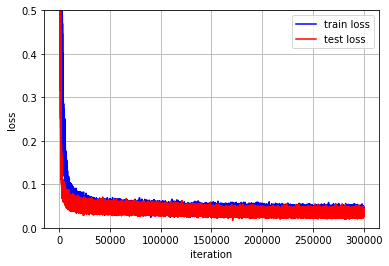

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.grid()
plt.plot(loss_vec,c='b',linestyle='solid',label='train loss')
plt.plot(test_loss_vec,c='r',label='test loss')

#plt.xlim(60000,60100)
plt.ylim(0,0.5)
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
plt.savefig(str(hidden_size)+'.png')
plt.legend()


#print(test_loss_vec[99999])
#print(test_loss_vec[99999])

In [11]:
# 重みの保存
saver = tf.train.Saver()
saver.save(sess, './model.ckpt')


'./model.ckpt'

In [12]:
'''
# ボール座標とスティックの傾きプロット
by_max=IN_train.max(axis=0)[1]
by_min=IN_train.min(axis=0)[1]

ball_y = np.array(range(int(by_min)-3,int(by_max)+3))
for i in range(len(ball_y)):
    
    ball = np.array([[6.0, ball_y[i]/10.0]])
    
    print(ball)
    joy = sess.run(final_output, feed_dict={INPUT: ball})
    plt.scatter(ball[0][1],ball[0][0], s=200, c='orange')
    
    plt.quiver(0,0,-joy[0][0],-joy[0][1],angles="xy",scale_units="xy",scale=1)
    #plt.quiver(0,0,-0.6,5,angles="xy",scale_units="xy",scale=1)
    print(joy)
    plt.savefig(str(hidden_size)+'_img'+'.png')
    '''

'\n# ボール座標とスティックの傾きプロット\nby_max=IN_train.max(axis=0)[1]\nby_min=IN_train.min(axis=0)[1]\n\nball_y = np.array(range(int(by_min)-3,int(by_max)+3))\nfor i in range(len(ball_y)):\n    \n    ball = np.array([[6.0, ball_y[i]/10.0]])\n    \n    print(ball)\n    joy = sess.run(final_output, feed_dict={INPUT: ball})\n    plt.scatter(ball[0][1],ball[0][0], s=200, c=\'orange\')\n    \n    plt.quiver(0,0,-joy[0][0],-joy[0][1],angles="xy",scale_units="xy",scale=1)\n    #plt.quiver(0,0,-0.6,5,angles="xy",scale_units="xy",scale=1)\n    print(joy)\n    plt.savefig(str(hidden_size)+\'_img\'+\'.png\')\n    '

In [13]:
# 重みのrestore
predicts_sess = tf.Session(config=config)
ckpt = tf.train.get_checkpoint_state('./')
if ckpt == None:
    print('!!!!!!!WEIGHTS NOT FOUND!!!!!!')

saver.restore(predicts_sess, './model.ckpt')

INFO:tensorflow:Restoring parameters from ./model.ckpt
